In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from re import split
from collections import defaultdict
import numpy as np

In [45]:
factor_to_celltype = {
    "0": "Astrocytes",
    "1": "Immune",
    "2": "ECs",
    "3": "Ependymal",
    "4": "Macrophages",
    "5": "Microglia",
    "6": "Neurons-Gaba",
    "7": "Neurons-Gaba",
    "8": "Neurons-Glut",
    "9": "Neurons-Other",
    "10": "Neurons-Immature",
    "11": "Neurons-Other",
    "12": "Astrocytes/Immune",
    "13": "OPCs",
    "14": "Oligodendrocytes",
    "15": "SMCs-Pericytes",
    "16": "SMCs",
    "17": "Fibroblasts",
    "18": "Fibroblasts",
    "19": "Astrocytes",
    "20": "Neurons-Dopa"
}

true_cluster = {
    "Astrocytes" : ["Astrocytes", "Astroependymal"],
    "Astrocytes/Immune" : ["Astrocytes", "Astroependymal", "Immune-Other"],
    "ECs": ["ECs"],
    "Ependymal": ["Astroependymal", "Ependymal"],
    "Fibroblasts": ["VLMCs"],
    "Immune": ["Immune-Other"],
    "Macrophages": ["BAMs"],
    "Microglia": ["Microglia"],
    "Neurons-Dopa": ["Neurons-Dopa"],
    "Neurons-Gaba": ["Neurons-Gaba", "Neurons-Glyc-Gaba"],
    "Neurons-Glut": ["Neurons-Glut"],
    "Neurons-Immature": ["Neurons-Granule-Immature"],
    "Neurons-Other": ["Neurons-Other", "Neurons-Dopa", "Neurons-Gaba", "Neurons-Glut", "Neurons-Glyc-Gaba", "Neurons-Granule-Immature", "Neurons-Other"],
    "OPCs": ["OPCs"],
    "Oligodendrocytes": ["Oligodendrocytes"],
    "SMCs-Pericytes": ["Pericytes", "SMCs"],
    "SMCs": ["SMCs"]
}

In [31]:
def rename(colnames):
    mapper = {}
    for col in colnames:
        mapper[col] = split("_", col)[1]
    return mapper
data_path = "/Users/jonasflor/Downloads"
general_stats = pd.read_csv(data_path + "/general_stats.csv", index_col=0)
area_weight = pd.read_csv(data_path + "/Ficture_stats" + "/area_weight.csv", index_col=0)
area_weight.rename(columns=rename(area_weight.columns), inplace=True)
area = pd.read_csv(data_path + "/Ficture_stats" + "/area.csv", index_col=0)
area.rename(columns=rename(area.columns), inplace=True)
means = pd.read_csv(data_path + "/Ficture_stats" + "/means.csv", index_col=0)
means.rename(columns=rename(means.columns), inplace=True)
means_weight = pd.read_csv(data_path + "/Ficture_stats" + "/means_weight.csv", index_col=0)
means_weight.rename(columns=rename(means_weight.columns), inplace=True)
vars = pd.read_csv(data_path + "/Ficture_stats" + "/vars.csv", index_col=0)
vars.rename(columns=rename(vars.columns), inplace=True)
vars_weight = pd.read_csv(data_path + "/Ficture_stats" + "/vars_weight.csv", index_col=0)
vars_weight.rename(columns=rename(vars_weight.columns), inplace=True)
annotation = pd.read_csv(data_path + "/adata_obs_annotated (1).csv", index_col=0).rename(columns={"cell_type_mmc_incl_mixed_revised": "cell type"})

In [44]:
area

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
aaaaaaaa-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaaaaaab-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaaaaaac-1,79.0,0.0,195.0,0.0,0.0,61.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0
aaaaaaad-1,18.0,0.0,10.0,0.0,0.0,187.0,0.0,0.0,11.0,0.0,...,352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,277.0
aaaaaaae-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,...,554.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,425.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aaaamnce-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1474.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0
aaaamncf-1,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaaamncg-1,21.0,20.0,0.0,13.0,0.0,0.0,1683.0,0.0,8.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaaamnch-1,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,258.0,0.0,0.0,0.0,0.0,0.0,0.0


/var/folders/b7/2447cny161d6nzl8rj07yssr0000gn/T/ipykernel_30798/674317428.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = ((area.groupby(area.columns, axis=1).sum()/
/var/folders/b7/2447cny161d6nzl8rj07yssr0000gn/T/ipykernel_30798/674317428.py:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  general_stats.groupby(general_stats.columns, axis=1).sum().iloc[0].values)
/var/folders/b7/2447cny161d6nzl8rj07yssr0000gn/T/ipykernel_30798/674317428.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = grouped.groupby(grouped.columns, axis=1).sum()
/var/folders/b7/2447cny161d6nzl8rj07yssr0000gn/T/ipykernel_30798/674317428.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_weight = ((area_weight.groupby(area_weight

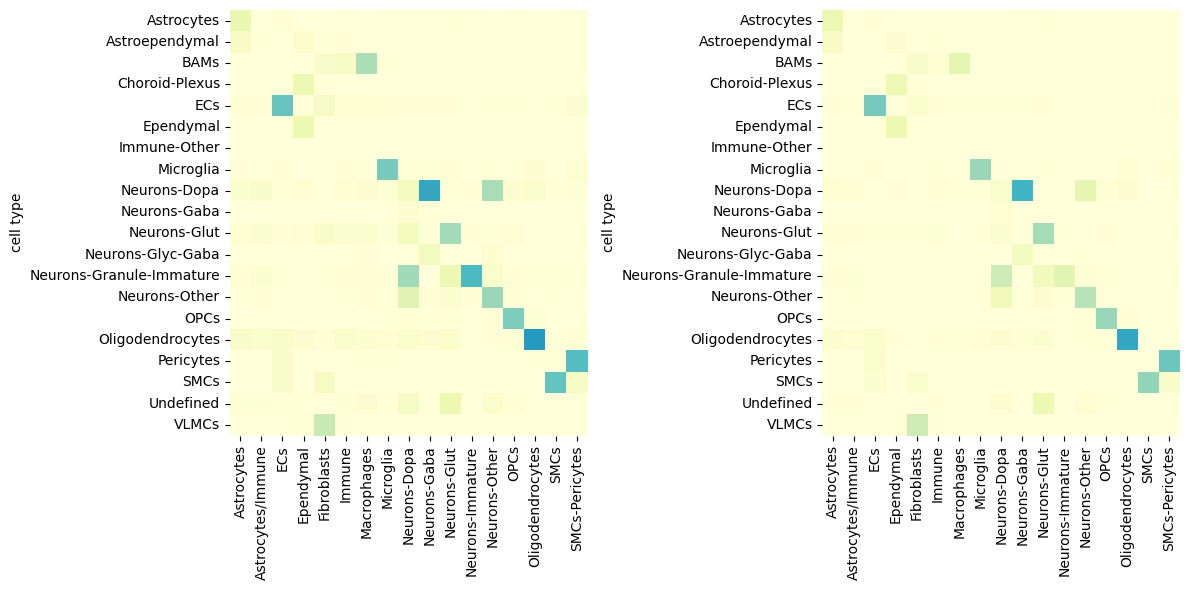

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

grouped = ((area.groupby(area.columns, axis=1).sum()/
        general_stats.groupby(general_stats.columns, axis=1).sum().iloc[0].values)
       .merge(annotation["cell type"], how='left', left_index=True, right_index=True)
       .groupby("cell type").sum())
grouped = grouped.groupby(grouped.columns, axis=1).sum()

grouped_weight = ((area_weight.groupby(area_weight.columns, axis=1).sum()/
        general_stats.groupby(general_stats.columns, axis=1).sum().iloc[0].values)
       .merge(annotation["cell type"], how='left', left_index=True, right_index=True)
       .groupby("cell type").sum())
grouped_weight = grouped_weight.groupby(grouped_weight.columns, axis=1).sum()

sns.heatmap(grouped, fmt="g", cmap="YlGnBu", ax=axes[0], vmin=0, vmax=1, cbar=False)
sns.heatmap(grouped_weight, fmt="g", cmap="YlGnBu", ax=axes[1], vmin=0, vmax=1, cbar=False)

plt.tight_layout()
plt.show()

In [144]:
grouped

,Astrocytes,Astrocytes/Immune,ECs,Ependymal,Fibroblasts,Immune,Macrophages,Microglia,Neurons-Dopa,Neurons-Gaba,Neurons-Glut,Neurons-Immature,Neurons-Other,OPCs,Oligodendrocytes,SMCs,SMCs-Pericytes
cell type,,,,,,,,,,,,,,,,,
Astrocytes,0.138093,0.002415,0.018966,0.003076,0.001924,0.005222,0.002962,0.006114,0.004268,0.007213,0.010370,0.004655,0.001336,0.005090,0.002241,0.002745,0.004915
Astroependymal,0.061335,0.008011,0.003858,0.042545,0.009485,0.015120,0.007535,0.007114,0.002524,0.001961,0.001993,0.004817,0.003764,0.007365,0.003225,0.004129,0.004851
BAMs,0.001076,0.000537,0.004338,0.003993,0.054680,0.057002,0.300361,0.010515,0.000141,0.000138,0.000040,0.000084,0.000303,0.000297,0.000816,0.007786,0.004898
Choroid-Plexus,0.000048,0.000000,0.002262,0.117821,0.011226,0.000000,0.000000,0.000365,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000160,0.000218,0.002250
ECs,0.020573,0.013492,0.423938,0.010499,0.064888,0.025936,0.025374,0.019435,0.013844,0.012939,0.014028,0.005019,0.009955,0.011421,0.005255,0.009502,0.033696
Ependymal,0.001304,0.000000,0.000770,0.122078,0.000572,0.000462,0.001610,0.003122,0.001523,0.000278,0.000295,0.000127,0.000231,0.001873,0.001089,0.000329,0.000077
Immune-Other,0.000039,0.000383,0.000023,0.000060,0.000030,0.000318,0.000386,0.000112,0.000213,0.000888,0.000865,0.000030,0.000305,0.000037,0.000007,0.000049,0.000297
Microglia,0.012724,0.005021,0.016517,0.006133,0.004039,0.015022,0.008308,0.389337,0.009535,0.009750,0.012824,0.002799,0.010455,0.006142,0.027842,0.002100,0.026273
Neurons-Dopa,0.035817,0.047376,0.011139,0.025778,0.006916,0.027217,0.028658,0.022429,0.089413,0.547565,0.009562,0.012794,0.303422,0.028793,0.043059,0.009112,0.014143


True positive: percentage of correctly assigned area ||
False positive: percentage of wrongly assinged area ||
False negative: percentage of wrongly unassigned area = 1-(TP-FP)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, 'Astrocytes'),
  Text(1, 0, 'Astrocytes/Immune'),
  Text(2, 0, 'ECs'),
  Text(3, 0, 'Ependymal'),
  Text(4, 0, 'Fibroblasts'),
  Text(5, 0, 'Immune'),
  Text(6, 0, 'Macrophages'),
  Text(7, 0, 'Microglia'),
  Text(8, 0, 'Neurons-Dopa'),
  Text(9, 0, 'Neurons-Gaba'),
  Text(10, 0, 'Neurons-Glut'),
  Text(11, 0, 'Neurons-Immature'),
  Text(12, 0, 'Neurons-Other'),
  Text(13, 0, 'OPCs'),
  Text(14, 0, 'Oligodendrocytes'),
  Text(15, 0, 'SMCs-Pericytes'),
  Text(16, 0, 'SMCs'),
  Text(17, 0, 'Total')])

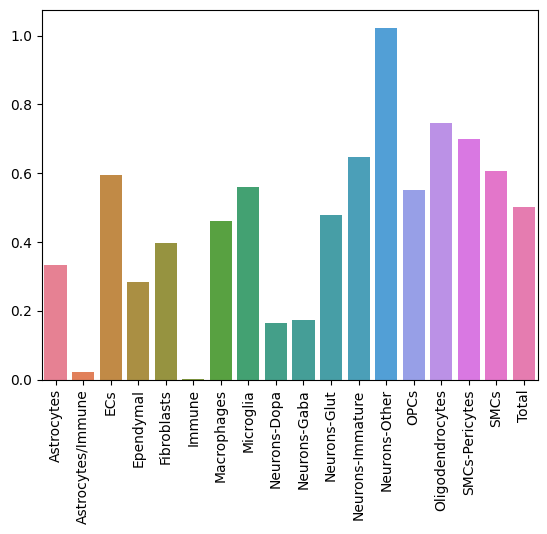

In [175]:
rates = {}
def f1_score(TP, FP, FN):
    return (2 * TP) / (2 * TP + FP + FN)
for cluster, correct_elements in true_cluster.items():
    rates[cluster] = defaultdict(float)
    rates[cluster]["TP"] = grouped[cluster].loc[correct_elements].sum()
    rates[cluster]["FP"] = grouped[cluster].loc[[col not in correct_elements for col in grouped.index]].sum()
    rates[cluster]["FN"] = 1-rates[cluster]["TP"]-rates[cluster]["FP"]
    rates[cluster]["F1_score"] = f1_score(rates[cluster]["TP"], rates[cluster]["FP"], rates[cluster]["FN"])

f1_stats = defaultdict(float)
for cluster, correct_elements in rates.items():
    f1_stats["TP"] += rates[cluster]["TP"]
    f1_stats["FP"] += rates[cluster]["FP"]
    f1_stats["FN"] += rates[cluster]["FN"]
f1_stats["F1_score"] = f1_score(f1_stats["TP"], f1_stats["FP"], f1_stats["FN"])

stats_total = []
names = []
for cluster, correct_elements in rates.items():
    names.append(cluster)
    stats_total.append(rates[cluster]["F1_score"])
names.append("Total")
stats_total.append(f1_stats["F1_score"])
stats_total = pd.DataFrame(stats_total, index=names, columns=["F1_statistics"]).T

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, 'Astrocytes'),
  Text(1, 0, 'Astrocytes/Immune'),
  Text(2, 0, 'ECs'),
  Text(3, 0, 'Ependymal'),
  Text(4, 0, 'Fibroblasts'),
  Text(5, 0, 'Immune'),
  Text(6, 0, 'Macrophages'),
  Text(7, 0, 'Microglia'),
  Text(8, 0, 'Neurons-Dopa'),
  Text(9, 0, 'Neurons-Gaba'),
  Text(10, 0, 'Neurons-Glut'),
  Text(11, 0, 'Neurons-Immature'),
  Text(12, 0, 'Neurons-Other'),
  Text(13, 0, 'OPCs'),
  Text(14, 0, 'Oligodendrocytes'),
  Text(15, 0, 'SMCs-Pericytes'),
  Text(16, 0, 'SMCs'),
  Text(17, 0, 'Total')])

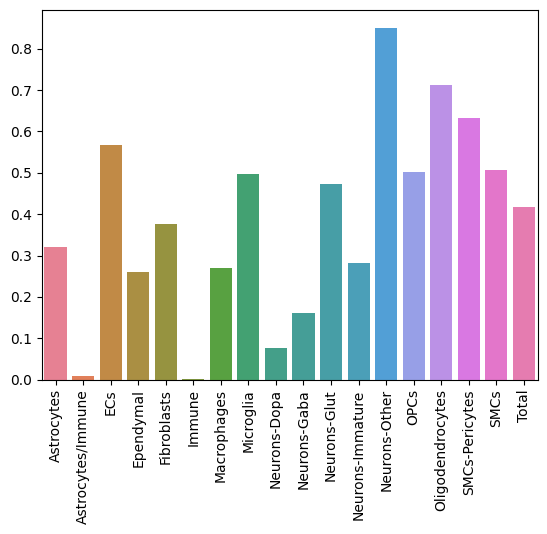

In [178]:
rates = {}
def f1_score(TP, FP, FN):
    return (2 * TP) / (2 * TP + FP + FN)
for cluster, correct_elements in true_cluster.items():
    rates[cluster] = defaultdict(float)
    rates[cluster]["TP"] = grouped_weight[cluster].loc[correct_elements].sum()
    rates[cluster]["FP"] = grouped_weight[cluster].loc[[col not in correct_elements for col in grouped_weight.index]].sum()
    rates[cluster]["FN"] = 1-rates[cluster]["TP"]-rates[cluster]["FP"]
    rates[cluster]["F1_score"] = f1_score(rates[cluster]["TP"], rates[cluster]["FP"], rates[cluster]["FN"])

f1_stats = defaultdict(float)
for cluster, correct_elements in rates.items():
    f1_stats["TP"] += rates[cluster]["TP"]
    f1_stats["FP"] += rates[cluster]["FP"]
    f1_stats["FN"] += rates[cluster]["FN"]
f1_stats["F1_score"] = f1_score(f1_stats["TP"], f1_stats["FP"], f1_stats["FN"])

stats_total_weight = []
names = []
for cluster, correct_elements in rates.items():
    names.append(cluster)
    stats_total_weight.append(rates[cluster]["F1_score"])
names.append("Total")
stats_total_weight.append(f1_stats["F1_score"])
stats_total_weight = pd.DataFrame(stats_total_weight, index=names, columns=["F1_statistics"]).T

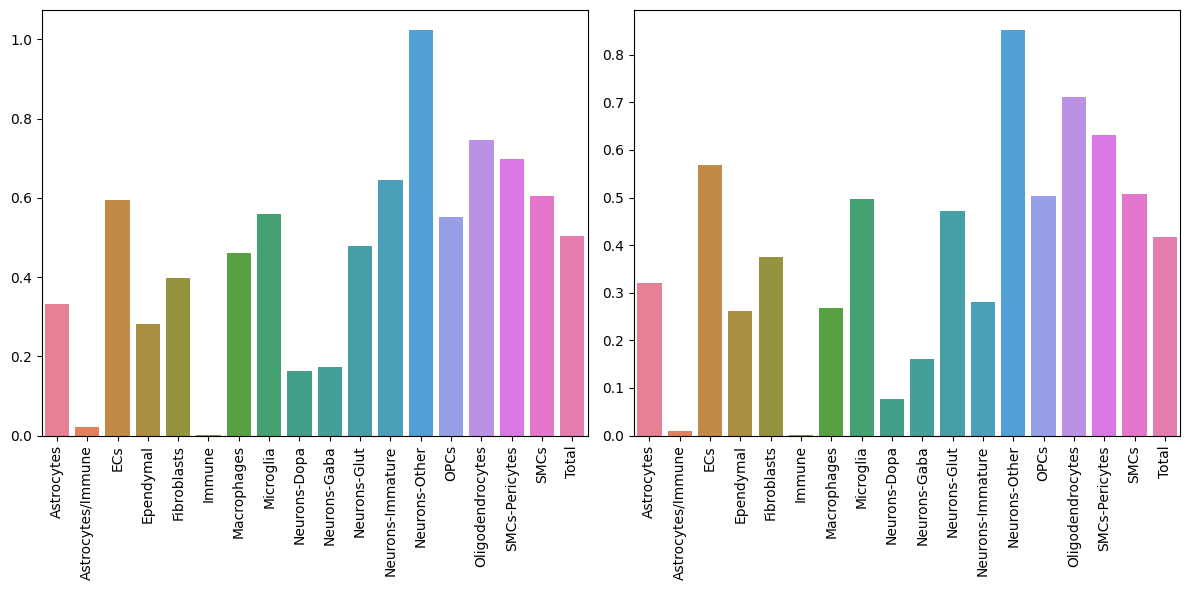

In [180]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


sns.barplot(data=stats_total, ax=axes[0])
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(data=stats_total_weight, ax=axes[1])
plt.xticks(rotation=90)

plt.tight_layout()

In [50]:
correct_celltypes = {}
for i in factor_to_celltype.keys():
    correct_celltypes[i] = true_cluster[factor_to_celltype[i]]
data = ((area.groupby(area.columns, axis=1).sum()/
        general_stats.groupby(general_stats.columns, axis=1).sum().iloc[0].values)
       .merge(annotation["cell type"], how='left', left_index=True, right_index=True))

data_weight = ((area_weight.groupby(area_weight.columns, axis=1).sum()/
        general_stats.groupby(general_stats.columns, axis=1).sum().iloc[0].values)
       .merge(annotation["cell type"], how='left', left_index=True, right_index=True))

/var/folders/b7/2447cny161d6nzl8rj07yssr0000gn/T/ipykernel_35019/802617472.py:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data = ((area.groupby(area.columns, axis=1).sum()/
/var/folders/b7/2447cny161d6nzl8rj07yssr0000gn/T/ipykernel_35019/802617472.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  general_stats.groupby(general_stats.columns, axis=1).sum().iloc[0].values)
/var/folders/b7/2447cny161d6nzl8rj07yssr0000gn/T/ipykernel_35019/802617472.py:8: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data_weight = ((area_weight.groupby(area_weight.columns, axis=1).sum()/
/var/folders/b7/2447cny161d6nzl8rj07yssr0000gn/T/ipykernel_35019/802617472.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  general_stats.groupby(general_stats.co

In [42]:
def compute_f1(data, correct_celltypes):
    """
    Computes the F1 score given a set of correct elements.
    Args:
        data: Data with factors and celltype annotation.
        correct_celltypes: specify correct celltype per factor.

    Returns:
        F1 score per factor and over all factors.
    """
    def f1_score(TP, FP, FN):
        return (2 * TP) / (2 * TP + FP + FN)

    rates = {}

    for cluster, elements in correct_celltypes.items():
        rates[cluster] = defaultdict(float)
        rates[cluster]["TP"] = data[cluster][[x in elements for x in data["cell type"]]].sum()
        rates[cluster]["FP"] = data[cluster][[x not in elements for x in data["cell type"]]].sum()
        rates[cluster]["FN"] = 1-rates[cluster]["TP"]-rates[cluster]["FP"]
        rates[cluster]["F1_score"] = f1_score(rates[cluster]["TP"], rates[cluster]["FP"], rates[cluster]["FN"])

    f1_stats = defaultdict(float)
    for stats in rates.values():
        f1_stats["TP"] += stats["TP"]
        f1_stats["FP"] += stats["FP"]
        f1_stats["FN"] += stats["FN"]
    f1_stats["F1_score"] = f1_score(f1_stats["TP"], f1_stats["FP"], f1_stats["FN"])

    stats_total = []
    names = []
    for cluster, stats in rates.items():
        names.append(cluster)
        stats_total.append(stats["F1_score"])
    names.append("Total")
    stats_total.append(f1_stats["F1_score"])
    stats_total = pd.DataFrame(stats_total, index=names, columns=["F1_statistics"]).T
    return stats_total

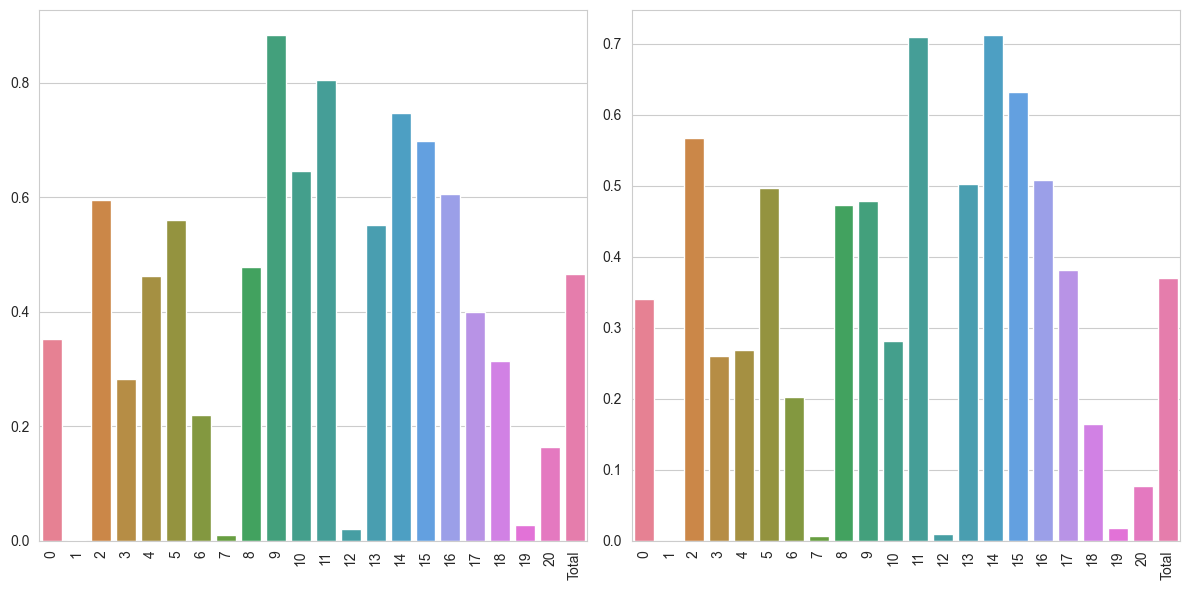

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(data=compute_f1(data, correct_celltypes), ax=axes[0])
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(data=compute_f1(data_weight, correct_celltypes), ax=axes[1])
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [79]:
def compute_f1(data):
    """
    Computes the F1 score given a set of correct elements.
    Args:
        data: Data with factors and celltype annotation.
        correct_celltypes: specify correct celltype per factor.

    Returns:
        F1 score per factor and over all factors.
    """
    def f1_score(TP, FP, FN):
        return (2 * TP) / (2 * TP + FP + FN)

    f1_stats = np.ones((len(data.drop(columns=["cell type"]).columns), len(data["cell type"].unique())))

    for i, factor in enumerate(data.drop(columns=["cell type"]).columns):
        for j, celltype in enumerate(data["cell type"].unique()):
            TP = data[factor][data["cell type"]==celltype].sum()
            FP = data[factor][data["cell type"]!=celltype].sum()
            FN = 1-TP-FP
            f1_stats[i,j] = f1_score(TP, FP, FN)

    return pd.DataFrame(f1_stats, index=data["cell type"].unique(), columns=data.drop(columns=["cell type"]).columns)

In [80]:
compute_f1(data)

,0,1,10,11,12,13,14,15,16,17,...,19,2,20,3,4,5,6,7,8,9
ECs,0.040197,0.047766,0.018623,0.071906,0.015759,0.122615,0.038322,0.258069,0.025909,0.007972,...,0.0,0.093502,0.013356,0.006307,0.002303,0.004736,0.002613,0.000073,0.032483,0.000102
Neurons-Glut,0.050560,0.069118,0.018100,0.052991,0.010120,0.029790,0.045014,0.010390,0.029599,0.013236,...,0.0,0.075511,0.007626,0.005804,0.107857,0.004462,0.001984,0.000636,0.029952,0.000000
Neurons-Other,0.009987,0.028067,0.025561,0.025264,0.003417,0.009588,0.010052,0.009266,0.005583,0.000350,...,0.0,0.014767,0.002116,0.002967,0.000168,0.000141,0.002047,0.000060,0.646054,0.000000
Neurons-Dopa,0.018967,0.019317,0.648011,0.214440,0.026747,0.010297,0.082362,0.002723,0.019382,0.001731,...,0.0,0.032541,0.003975,0.000471,0.000424,0.000223,0.000041,0.000096,0.119921,0.000000
OPCs,0.026625,0.063681,0.038126,0.090467,0.003978,0.015895,0.044669,0.004818,0.009992,0.003444,...,0.0,0.078300,0.005352,0.004207,0.001073,0.000000,0.000843,0.000766,0.061954,0.000000
Astroependymal,0.022584,0.049180,0.025484,0.055975,0.551137,0.014622,0.032042,0.010128,0.012210,0.001825,...,0.0,0.044232,0.011980,0.005023,0.000594,0.001316,0.003384,0.000073,0.031666,0.000005
Undefined,0.010455,0.013705,0.004163,0.082563,0.043302,0.006429,0.012228,0.004473,0.054176,0.001223,...,0.0,0.746350,0.018763,0.005623,0.001632,0.001575,0.002733,0.000013,0.018682,0.000320
Astrocytes,0.065195,0.022397,0.007281,0.027892,0.009483,0.009655,0.019044,0.009782,0.051200,0.135975,...,0.0,0.041743,0.633502,0.002262,0.009748,0.010408,0.001173,0.000593,0.018860,0.004491
Microglia,0.018826,0.012260,0.016843,0.018059,0.003004,0.008224,0.014984,0.005475,0.004192,0.604859,...,0.0,0.018314,0.022685,0.004536,0.015452,0.015491,0.000163,0.000098,0.022691,0.000436
SMCs,0.124649,0.100873,0.004987,0.013406,0.001515,0.018883,0.008797,0.003226,0.007716,0.123707,...,0.0,0.025846,0.005854,0.001135,0.106587,0.400155,0.000156,0.000061,0.014781,0.022927


In [54]:
means.head(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
aaaaaaaa-1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
aaaaaaab-1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
aaaaaaac-1,0.006968,0.0,0.017200,0.0,0.0,0.005381,0.0,0.0,0.000000,0.00000,...,0.006086,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.005998
aaaaaaad-1,0.000930,0.0,0.000517,0.0,0.0,0.009659,0.0,0.0,0.000568,0.00000,...,0.018181,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.014307
aaaaaaae-1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00261,...,0.043815,0.0,0.0,0.0,0.000554,0.0,0.0,0.0,0.0,0.033613


<Axes: xlabel='factor', ylabel='mean'>

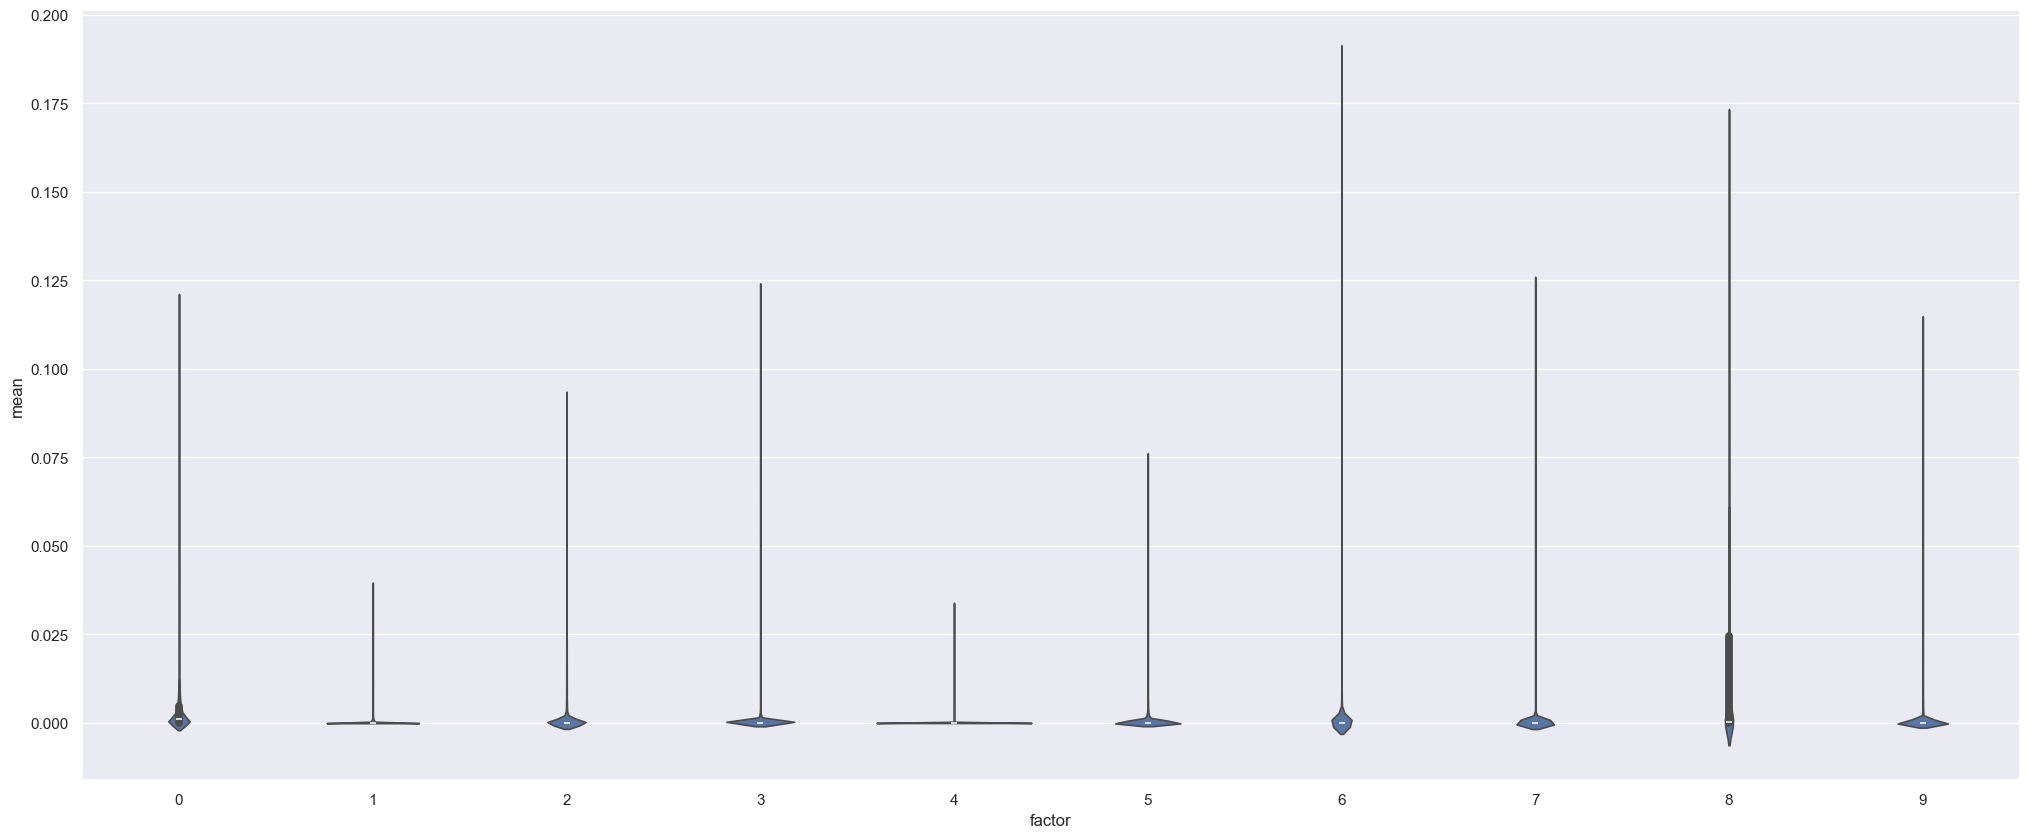

In [61]:
sns.set_theme(rc={'figure.figsize':(25,10)})
sns.violinplot(pd.melt(means[["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]], var_name="factor", value_name="mean"), x="factor", y="mean")

<Axes: xlabel='factor', ylabel='mean'>

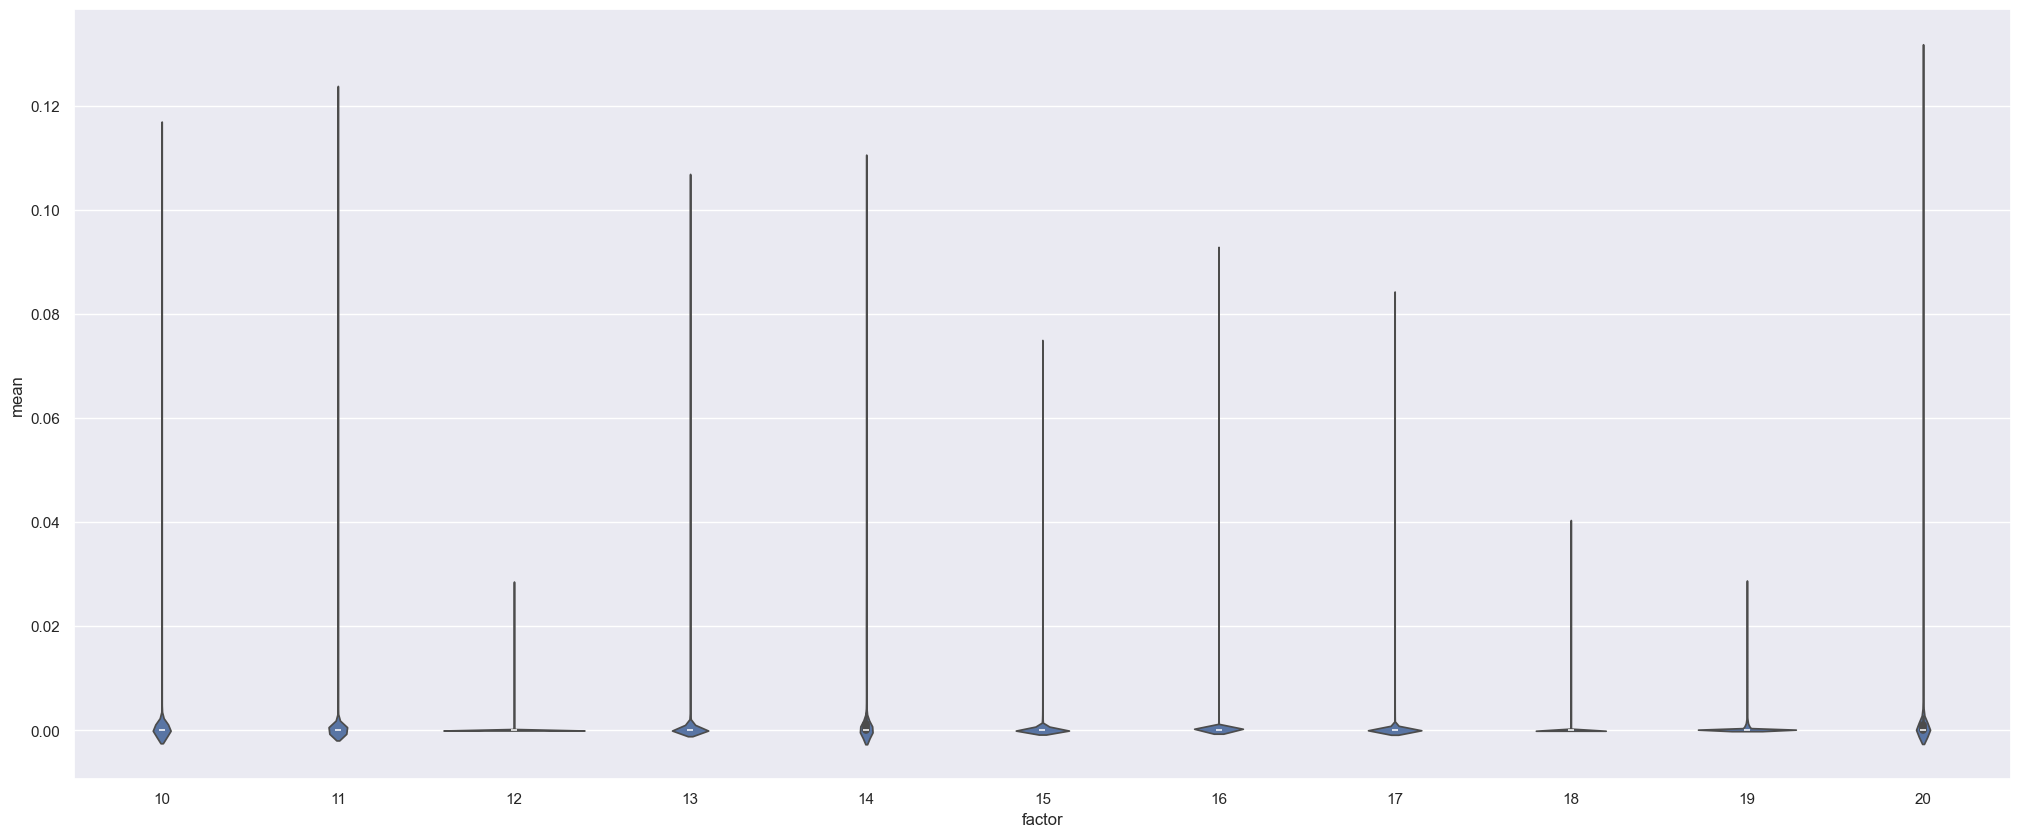

In [62]:
sns.set_theme(rc={'figure.figsize':(25,10)})
sns.violinplot(pd.melt(means[["10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"]], var_name="factor", value_name="mean"), x="factor", y="mean")